In [2]:
import pysam
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from Bio import SeqIO
import pandas as pd

In [2]:
!samtools flagstat "frag_aln.sam"
print('\n')
!samtools flagstat "jump_aln.sam"

3432529 + 0 in total (QC-passed reads + QC-failed reads)
0 + 0 secondary
165 + 0 supplementary
0 + 0 duplicates
3419327 + 0 mapped (99.62% : N/A)
3432364 + 0 paired in sequencing
1716182 + 0 read1
1716182 + 0 read2
0 + 0 properly paired (0.00% : N/A)
3405960 + 0 with itself and mate mapped
13202 + 0 singletons (0.38% : N/A)
0 + 0 with mate mapped to a different chr
0 + 0 with mate mapped to a different chr (mapQ>=5)


4328969 + 0 in total (QC-passed reads + QC-failed reads)
0 + 0 secondary
13369 + 0 supplementary
0 + 0 duplicates
4271451 + 0 mapped (98.67% : N/A)
4315600 + 0 paired in sequencing
2157800 + 0 read1
2157800 + 0 read2
0 + 0 properly paired (0.00% : N/A)
4200762 + 0 with itself and mate mapped
57320 + 0 singletons (1.33% : N/A)
0 + 0 with mate mapped to a different chr
0 + 0 with mate mapped to a different chr (mapQ>=5)


In [62]:
def aln2cov(samfile, ref_file):
    samfile = pysam.AlignmentFile(samfile, "rb")
    refseq = SeqIO.read(ref_file, "fasta").seq
    coverage = {}
    
    for read in samfile.fetch():
        start_read, end_read = read.reference_start, read.reference_end
        if start_read and end_read: # Check mapped
            for pos in range(start_read, end_read):
                if pos in coverage:
                    coverage[pos] += 1
                else:
                    coverage[pos] = 1
    samfile.close()
    return coverage

def mean_coverage(dict_coverage):
    return np.array(list(dict_coverage.values())).mean()

def count_coverage(dict_coverage, refrence_sequance):
    return round(len(dict_coverage.keys()) / len(refrence_sequance), 15)

def plot_coverage(dict_coverage):
    x, y = list(dict_coverage.keys()), list(dict_coverage.values())
    plt.figure(figsize=(15, 10))
    plt.xlabel('Позиция нуклеотида в геноме')
    plt.ylabel('Количество ридов, которые покрыли нуклеотид')
    plt.axhline(y=mean_coverage(dict_coverage), label='Среднее покрытие', color='r', linestyle='--')
    plt.legend()
    sns.scatterplot(x, y)
    
def plot_indel(samfile):
    samfile = pysam.AlignmentFile(samfile, "r") 
    lenght_insertion = []
    lenght_deletion = []
    lenght_indel = []
    for x in samfile.fetch():
        if x.cigartuples:
            for type_indel, lenght in x.cigartuples:
                if type_indel == 1:
                    lenght_insertion.append(lenght)
                if type_indel == 2:
                    lenght_deletion.append(lenght)
                if type_indel == 1 or type_indel == 2:
                    lenght_indel.append(lenght)

    tempory_counters = [Counter(array) for array in [lenght_insertion, lenght_deletion, lenght_indel]]
    
    fig, ax = plt.subplots(figsize=(15, 10))
    for counter, label in zip(tempory_counters, ['insertion', 'deletion', 'indel']):
        x = list(counter.keys())
        y = list(counter.values())
        plt.plot(x, y, label=label, linewidth=2)

    plt.legend(loc=1, prop={'size': 16})
    plt.xlabel('Длина индела')
    plt.ylabel('Количество инделов с такой длиной')
    plt.grid()

def plot_kde_replacment(samfile):
    samfile = pysam.AlignmentFile(samfile, "r") 
    quality_indel = []
    for read in samfile.fetch():
        acnt, generator = -1, read.cigartuples
        if generator:
            for ind, cnt in generator:
                if ind == 0:
                    acnt += cnt
                if ind == 1:
                    quality_indel.append(ord(read.qual[acnt]) - 33)
    
    plt.figure(figsize=(15, 10))
    plt.xlabel('Качество нуклеотида')
    plt.ylabel('Частота')
    sns.kdeplot(quality_indel)
def template_lenght(samfile, confidience, scale=False):
    samfile = pysam.AlignmentFile(samfile, "r") 
    templates = []
    for x in samfile.fetch():
        if x.template_length > 0:
            templates.append(x.template_length)
            
    samfile.close()
    
    counter_templates = Counter(templates)
    x = np.array(list(range(len(counter_templates))))
    y = np.array([counter_templates[i] for i in range(len(counter_templates))])
    if scale:
        x, y = x[:1000], y[:1000]
        
    #draw temlates lenght
    plt.figure(figsize=(15, 10))
    plt.xlabel('Расстояние вставки')
    plt.ylabel('Количество с таким расстоянием вставки')
    plt.grid()
    
    # Calculate cond interval
    cnt, min_index_l, min_index_r = 0, 0, 0
    left, right = sum(y) * (1 - confidience) / 2, sum(y) * (1 + confidience) / 2
    for index, elem in enumerate(array[1]):
        cnt += elem
        if cnt > left and min_index_l == 0:
            min_index_l = index
        if cnt > right and min_index_r == 0:
            min_index_r = index
            break
    
    #draw other
    plt.axvline(x[min_index_l], linestyle='--', color='r', label='left confidence interval')
    plt.axvline(x[min_index_r], linestyle='--', color='r', label='right confidence interval')
    plt.legend()
    sns.scatterplot(x, y, color='k')
    return x, y

def matrix_substitutions(samfile, refrence):
    samfile = pysam.AlignmentFile(samfile, "rb")
    replacment = {'A' : [], 'G' : [], 'C' : [], 'T' : [], '_' : []}
    refseq = SeqIO.read(refrence, 'fasta')
    
    for read in samfile.fetch():
        generator, acc = [], 0
        if read.cigartuples:
            for ind, count in read.cigartuples:
                generator.append([ind, [acc, acc + count]])
                acc += count
            l_read, l_reference, counter_ind, cnt = 0, read.reference_start, 0, 0
            while l_read != len(read.seq):
                print(l_read)
                if generator[-1][0] == 0:
                    replacment[refseq[l_reference]].append(read.seq[l_read])
                    l_read += 1
                    l_reference += 1
                if generator[-1][0] == 1:
                    replacment['_'].append(read.seq[l_read])
                    l_reference += 1
                    l_read += 1
                if generator[-1][0] == 2:
                    replacment[refseq[l_reference]].append('_')
                    l_read += 1
                if generator[-1][0] == 4:
                    l_read += 1
                    l_reference += 1
                if l_read == generator[counter_ind][1][1]:
                    counter_ind += 1
    samfile.close()
    
    return replacment

def matrix_substitutions_2(samfile, refrence):
    samfile = pysam.AlignmentFile(samfile, threads=4)
    refseq = SeqIO.read(refrence, 'fasta')
    matrix = {nucl_1 : {nucl_2 : 0 for nucl_2 in ['A', 'G', 'C', 'T', '']} for nucl_1 in ['A', 'G', 'C', 'T']}
    for columns in samfile.pileup():
        ref_nucl = refseq[columns.reference_pos]
        for nucl in ['A', 'C', 'T', 'G', '']:
            matrix[ref_nucl][nucl] += Counter(columns.get_query_sequences())[nucl]
    return matrix

def mean_errors(matrix):
    df = pd.DataFrame(matrix)
    df['sum'] = df.sum(axis=1)
    df = df.div(df["sum"], axis=0)
    df = df.drop('sum', axis=1)
    return 100 * (4 - (df['A']['A'] + df['C']['C'] + df['G']['G'] + df['T']['T']))

In [37]:
SAM_FILE_FRAG = "frag_aln.sam"
SAM_FILE_JUMP = "jump_aln.sam"
BAM_FILE_FRAG = "frag_aln.bam"
BAM_FILE_JUMP = "jump_aln_sorted.bam"
REFERENCE_FILE = "ref.fasta"

refseq = SeqIO.read(REFERENCE_FILE, 'fasta').seq

In [6]:
coverage = aln2cov(SAM_FILE_FRAG, REFERENCE_FILE)

## Отчёт по 2A
#### 1. График покрытия генома, среднее покрытие, процент покрытого генома

Среднее покрытие генома: 130.5350067358416
Процент покрытого генома: 99.9999723374138 %


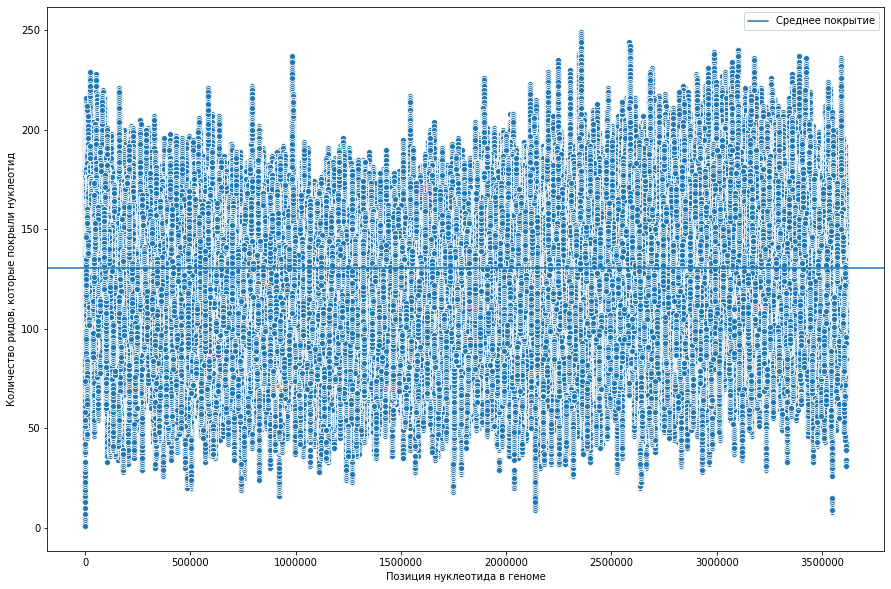

In [173]:
plot_coverage(coverage)
print('Среднее покрытие генома:', mean_coverage(coverage))
print('Процент покрытого генома:', count_coverage(coverage, refseq) * 100, '%')

#### 2. Распределение расстояния вставки

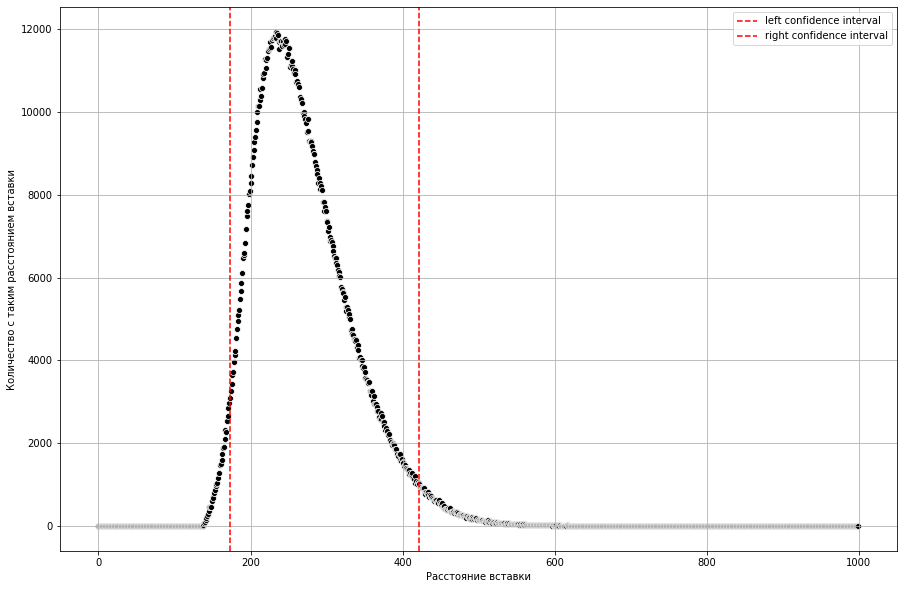

In [148]:
array = template_lenght(SAM_FILE_FRAG, confidience=0.95, scale=True)

#### 3. Матрица замен

## Отчёт по 2B

In [40]:
SAM_FILE_ALN_1 = "aln_1.sam"
SAM_FILE_ALN_2 = "aln_2.sam"
BAM_FILE_ALN_1 = "aln_1.bam"
BAM_FILE_ALN_2 = "aln_sorted_2.bam"
REFERENCE_FILE = "DH10B-K12.fasta"

refseq = SeqIO.read(REFERENCE_FILE, 'fasta').seq

In [180]:
coverage = aln2cov(SAM_FILE_ALN_1, REFERENCE_FILE)

#### 1. График покрытия генома, среднее покрытие, процент покрытого генома

Среднее покрытие генома: 34.03713890214471
Процент покрытого генома: 99.9879431608594 %


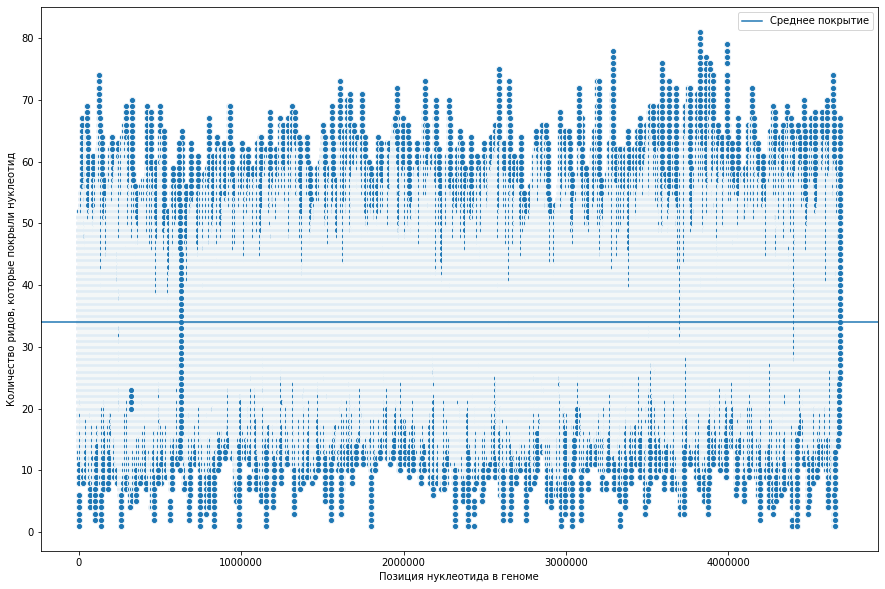

In [181]:
plot_coverage(coverage)
print('Среднее покрытие генома:', mean_coverage(coverage))
print('Процент покрытого генома:', count_coverage(coverage, refseq) * 100, '%')

#### 2. Средний процент ошибок в ридах

In [41]:
replacment_1 = matrix_substitutions_2(BAM_FILE_ALN_1, REFERENCE_FILE)
replacment_2 = matrix_substitutions_2(BAM_FILE_ALN_2, REFERENCE_FILE)

In [67]:
print('Средний процент ошибок в первом выравнивании: ', mean_errors(replacment_1), '%',sep='')
print('Средний процент ошибок в втором выравнивании: ', mean_errors(replacment_2), '%',sep='')

Средний процент ошибок в первом выравнивании: 0.3047476985897468%
Средний процент ошибок в втором выравнивании: 0.22957364591658092%


#### 3. Статистика длин инделов

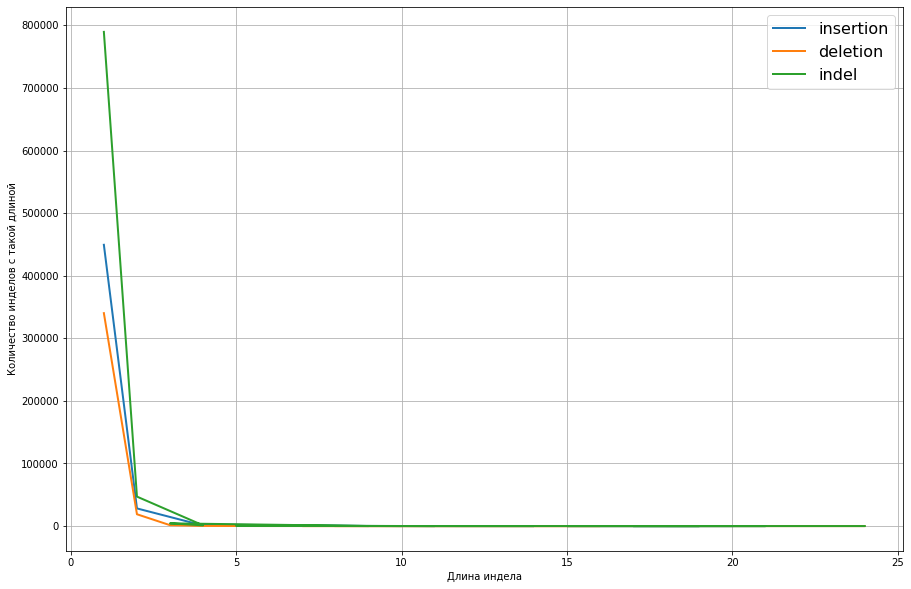

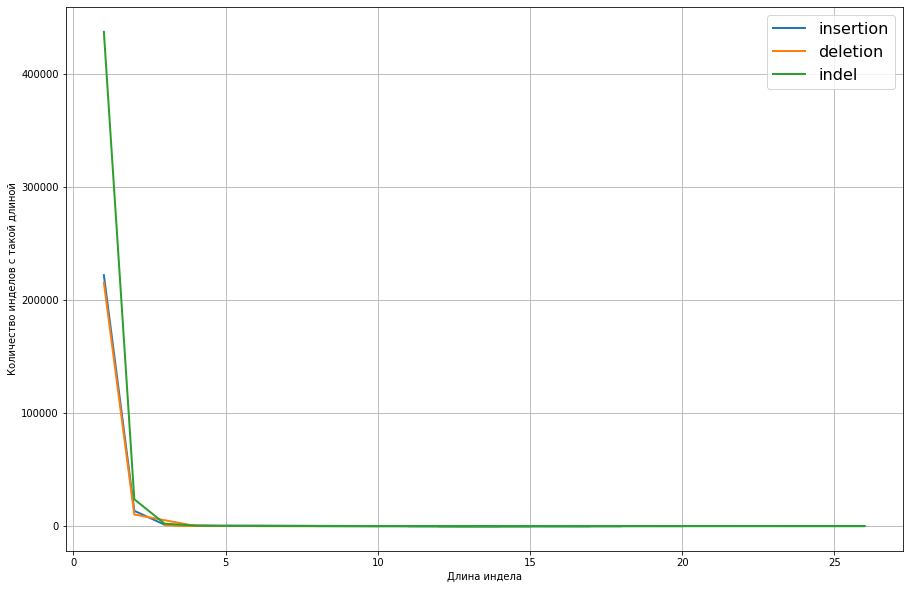

In [203]:
plot_indel(SAM_FILE_ALN_1)
plot_indel(SAM_FILE_ALN_2)

#### 4. Статистика длин инделов в завимости от длины гомополимерного участка 

In [ ]:
# Как по нуклеотиду найти рид?

#### 5. Статистика качества нуклеотидов
##### 5.1 При ошибочно вставленном нуклеотиде/замене

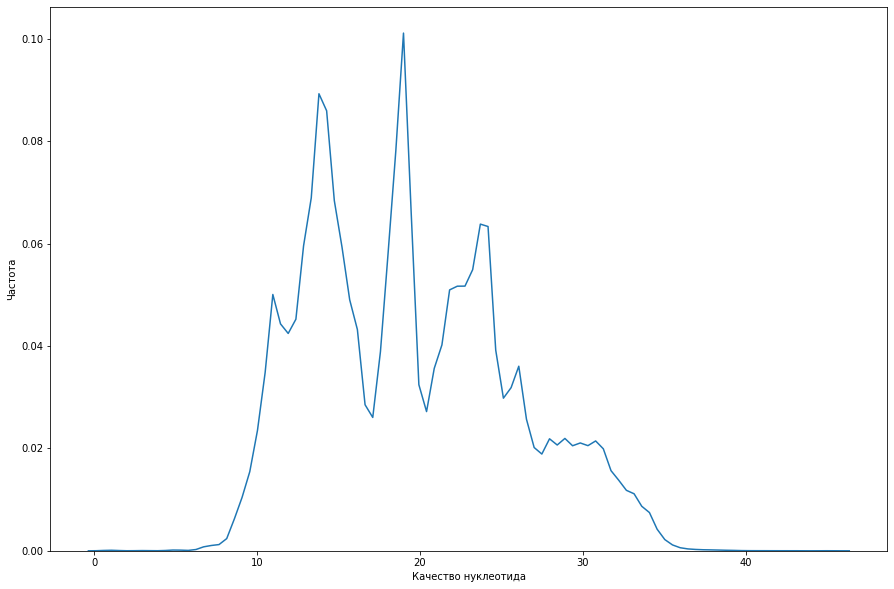

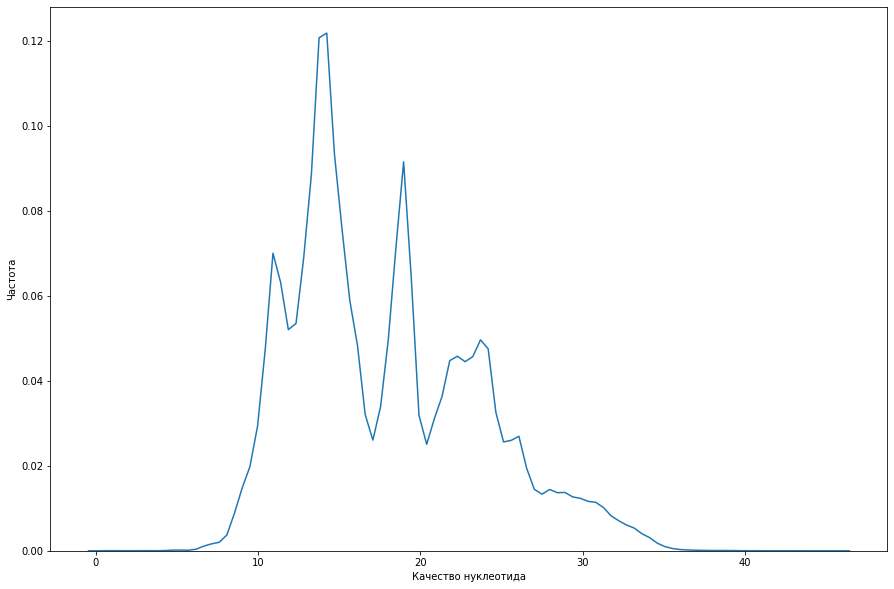

In [200]:
plot_kde_replacment(SAM_FILE_ALN_1)
plot_kde_replacment(SAM_FILE_ALN_2)

#### 5.2 Таблица частот замен вставок удалений

In [68]:
pd.DataFrame(replacment_1)

,A,G,C,T
A,38947411,13536,6759,7522
G,20116,38540314,5243,6101
C,6161,4676,38626318,20682
T,7397,6942,13032,38917600
,88856,57428,57546,89543


In [69]:
pd.DataFrame(replacment_2)

,A,G,C,T
A,40979430,11893,4598,4538
G,19312,41096151,3434,3397
C,3347,3200,41198182,19590
T,4472,4890,11661,40952861
,26798,70174,74177,27900
